# Collaboration and Competition

---

### 1. Start the Environment


In [4]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import torch
import time

from collections import deque
from maddpg.maddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def get_actions(states, add_noise):
    """Gets actions for each agent and then combines them into one array"""
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [10]:
def maddpg(n_episodes=10000, max_t=1000, print_every=10):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        print_every (int)     : interval to display results
    """
    scores_all = []
    moving_avgs = []
    best_score = -np.inf
    best_episode = 0
    scores_window = deque(maxlen=100)

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        
        while True:
            actions = get_actions(states, True)                # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_avgs.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % print_every == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-print_every, i_episode, np.max(scores_all[-print_every:]), moving_avgs[-1]))

        # determine if environment is solved and keep best performing models
        if moving_avgs[-1] >= 0.5 and i_episode >= 100:
            print('<-- Environment solved in {:d} episodes! \
            \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                i_episode-100, moving_avgs[-1], 100))
            
            # save weights
            torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            break
            
    return scores_all, moving_avgs

In [11]:
start_time = time.time()

In [12]:
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

In [13]:
scores, moving_avgs = maddpg()
end_time = time.time()

Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.010
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.007
Episodes 0030-0040	Max Reward: 0.000	Moving Average: 0.005
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.004
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.008
Episodes 0060-0070	Max Reward: 0.000	Moving Average: 0.007
Episodes 0070-0080	Max Reward: 0.200	Moving Average: 0.009
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.009
Episodes 0090-0100	Max Reward: 0.000	Moving Average: 0.008
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.009
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.008
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.009
Episodes 0130-0140	Max Reward: 0.000	Moving Average: 0.009
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.011
Episodes 0150-0160	Max Reward: 0.100	Moving Average: 0.009
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

In [17]:
print(f'Total time elapsed while training: {(end_time - start_time)/60.0} minutes')

Total time elapsed while training: 8.450972664356232 minutes


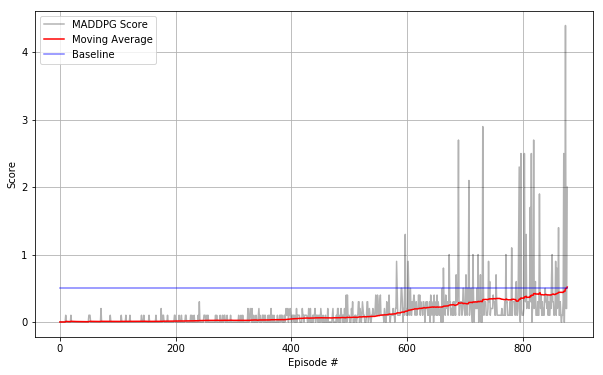

In [15]:
# plot the scores
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, c='k', label='MADDPG Score', alpha=0.3)
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='Moving Average')
plt.plot(np.arange(len(scores)), [0.5]*len(scores), c='b', label='Baseline', alpha=0.5)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.grid()
plt.savefig('scores_plot.png')
plt.show()

In [16]:
env.close()